# 55(row)x100(col)x750(height) Model Run using CFP 2019 Excecuatble

## 1.0. Setup

### 1.0.1. Imports

In [1]:
import os
import numpy as np
import numpy.ma as ma
import csv                                             
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import CFPy as cfpy

### 1.0.2. Directory 

In [2]:
# change active directory to model directory
path =""
if not os.path.exists(path):
    nb_dir = os.getcwd()
    path = os.path.join(nb_dir, "Karst_Conduit_Model")
    if not os.path.exists(path):
        os.makedirs(path)

## 1.1. Model Setup

### 1.1.1. Model Variables and ___

In [3]:
""" define model object """
os.chdir(path)
modelname = "base"
# using the CFPv2 here, which does support CADS
# to change, type in the correct CFP version for exe_name
# mf = flopy.modflow.Modflow(modelname, exe_name="CFPv2")

In [4]:
##Name:
modelname = "base"

##Grid:
n_rows = 55          #number of rows
n_cols = 100          #number of columns
delr = 10.       #width of each cell along rows (so really this is column width along x axis)
delc = 10.       #width of each cell along columns (so really this is row height along y axis)
Lx = n_cols*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = n_rows*delc     #width of domain in y (across rows) = number of rows x cell height

##Layers:
n_lays = 1                                                #number of layers
layers = np.arange(n_lays)                                #make array of layers
#add valley topography
# topo = []
# for i in range(n_rows):
#     topo.append([np.abs(i-27) + (723)])
# print(np.shape(topo))
# for j in range(n_cols-1):
#     for i in range(n_rows):
#         topo[i].append(topo[i][j] - 1)
# ztop = topo
#Flat Topography
ztop = np.ones((n_rows,n_cols)) * 750   #set top elevation of model (dim: n_rows,n_cols)
zbot = 0.                                               #bottom elevation of model (datum)
botm = np.full((n_lays,n_rows,n_cols),zbot)                   #make array of default cell bottom elevations for each cell in the model (dim:n_lays,n_rows,n_cols)
##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
K_horiz = 20. #10    #horizontal hydraulic conductivity (along rows)
K_ratio = 1.     #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
K_vert = 20. #10   #vertical hydraulic conductivity (along z axis)

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.1#.1         #porosity
Ss = 0.0001 #.0001     #specific storage
Sy = 0.1   #.01      #specific yield
uncnf = 1  #1      #if 0 then confined, if >0 then unconfined

## 1.2. Modflow Setup

In [5]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((n_lays,n_rows,n_cols),1)                            #make array of zeros for default boundary conditions (dim:n_lays,n_rows,n_cols)  #import locations of active and inactive cells from csv (all layers, all rows, all cols)
ibound[:,:,n_cols-1] = -1 #replace rightmost (eastern) column (slice all layers, active rows, last column) with -1 to indicate constant head
ibound[:,:,0] = -1 #set first row to constant head?

#create array of initial head values across the model and at the boundaries
H_init =690.                                #initial hydraulic head in meters
strt = np.full((n_lays, n_rows, n_cols), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value
strt[:,:,0] = 700
strt[:,:,n_cols-1] = 690

In [6]:
## Recharge conditions:
R = 0                              #recharge rate [m/day]
rech = np.zeros((n_rows,n_cols))          #make array of zeros for recharge (dim: n_rows, n_cols, no layers because recharge only happens in top layer)
rech[:,:] = R                      #set recharge in the leftmost 15 columns to the desired recharge rate

In [7]:
##Outputs:
#this section usually does not change - we are telling the model which outputs to print
oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

### 1.3 Write Inputs to Model and Run

### 1.3.1 Update .nam file 

In [8]:
#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='CFPv2')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, n_lays, n_rows, n_cols, delr=delr, 
                               delc=delc, top=ztop, botm=botm, steady=True)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf, mxiter=75, iter1=99, ihcofadd=9999, relax=0.97, nbpol=2, iprpcg=5, mutpcg=0)    #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)              

### With Conduit


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.
Elapsed time (.nbr file read): 0.0 s
(2, 55, 100)
(1, 55, 100)
Elapsed time (write nbr data): 0.05 s


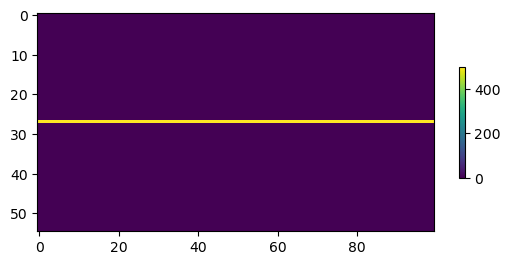

In [9]:
# Try to make 'compressed val conduit system' 20x25 instead of 80x100:
network = np.zeros((n_rows, n_cols))
network[27,:] = 500
# For tilted conduit (equation in y=mx+b format)
# for i in range(len(network[27])):
    # network[27,i] = np.round((((700 - 201)/(0 - n_cols-1)) * i) + 700) - 200
network_flipped = []
for i in range(len(network)):
    network_flipped.append(network[i][::-1])
    
elevations = np.zeros(np.shape(network))
for j in range(len(network)):
    for i in range(len(network[j])):
        if int(network[j,i]) != 0.0 and int(network[j,i]) != -999:
            elevations[j,i] = network[j,i]
            network[j,i] = 1

        else:
            network[j,i] = 0 
        
# generate MODFLOW layer elevation information
# here, single floats may be used if the layer elevations are uniform
layer_elevations = [ztop, np.full(np.shape(network), 0)]
validator = cfpy.preprocessing.GeneralValidator(network=network, elevations=elevations)
valid_network = validator.validate_network()

""" generating the .nbr-file """
# we use the same layer elevations here as in the MODFLOW model
validator.generate_nbr(
    nrows = n_rows,
    ncols = n_cols,
    nlays = n_lays,
    nplanes = 1,
    layer_elevations = layer_elevations
)

# plot the network
# TODO Können wir hier das schöne Bild wie in EX_02 generieren?
im = plt.imshow(valid_network)
plt.colorbar(im, shrink=0.3)

""" initialize nbr module """
# NOTE: make sure there is only 1 .nbr-file in the active domain!!
# if no or multiple .nbr-files are present, CFPy throws an error
nbr = cfpy.nbr()
# read model layer/node and conduit layer/node elevations

# bot_elev has shape (n_layers, n_rows, n_cols)
# cond_elev has shape (n_conduit_layers, n_rows, n_cols)
# function looks for an .nbr-file, if none or more than one file is found, an error is raised
# make sure to only have one .nbr-file in the working directory
bot_elev, cond_elev = nbr.nbr_read()

print(np.shape(bot_elev))
print(np.shape(cond_elev))

# create nbr-data
nbr_data = nbr.nbr(bot_elev, cond_elev)

In [10]:
# make pipe parametrization lists

# get pipe numbers
p_num = nbr_data[5]

# parametrization of all k pipes
# assuming same characteristics for all pipes
# lists for all conduit parametrization can be accessed individually to make differently parametrized pipes
# e.g., p_diameter[13] = 0.45

# global parameters

DIA = 1 #0.1
TOR = 1.0 # 1.0
KC  = 0.01 # 0.01
LRE = 10 # 10
HRE = 20 # 20

# diameter
p_diameter = np.ones(len(p_num)) * DIA
p_diameter = p_diameter.tolist()

# tortuosity
p_tortuosity = np.ones(len(p_num)) * TOR
p_tortuosity = p_tortuosity.tolist()

# roughness height
p_rheight = np.ones(len(p_num)) * KC
p_rheight = p_rheight.tolist()

# lower critical reynolds number
p_lcritrey = np.ones(len(p_num)) * LRE
p_lcritrey = p_lcritrey.tolist()

# higher critical reynolds number
p_hcritrey = np.ones(len(p_num)) * HRE
p_hcritrey = p_hcritrey.tolist()

# summarize all data in a 2D-array
pipe_data = [p_num, p_diameter, p_tortuosity, p_rheight, p_lcritrey, p_hcritrey]

In [11]:
# make lists for node head boundary conditions and tube-matrix exchange parameters

# get node numbers
n_num = nbr_data[0]

# parametrization for all n nodes
# if head > 0: fixed head
# if head == -1: calculated head
n_head = np.ones((len(n_num))) * -1
n_head = n_head.tolist()

# set individual node boundary conditions here
# e.g., for n_head[-1] the last node has a constant head given by the variable node_head_bc
# and for n_head[0] the first node has a constant head
# n_head[158] = node_head_bc #should be node 161 but zero indexed so 160? - uses node number here

# n_head[-1] = 
# n_head[]

# conduit wall conductivity in [m/d]
# identical for all conduits
# create list containing individual values to parametrize conduits individually
kex = 54. # was 54
k_exchange = np.ones((len(n_num))) * kex
k_exchange = k_exchange.tolist()

# summarize parametrization in lists
node_data = [n_num, n_head]
kex_data = [n_num, k_exchange]

In [12]:
""" initialize CFP module """

# if CADS should not be used or standard CFP (CFPv1) is used set cads = None below!

cfp = cfpy.cfp(mode = 1, # mode 1 == conduits, 2 == preferential flow layer (not supported), 3 == both (not supported)
               nnodes = len(n_num), 
               npipes = len(p_num), 
               nlay = n_lays, 
               nbr_data = nbr_data, 
               geoheight = cond_elev, 
               sa_exchange = 1, 
               epsilon = 0.000001,
               niter = 100, 
               relax = 1., 
               p_nr = 1., 
               cond_data = pipe_data, 
               n_head = node_data, 
               k_exchange = kex_data, 
               ncl = 0, 
               cl = 0, 
               ltemp = 25.,
               condl_data = 0,
               cads = None)

# create list of strings
cfp = cfp.cfp()

### 1.3.5 CFPy - COC (conduit output control)

In [13]:
""" initialize COC module """

coc = cfpy.coc(nnodes = len(nbr_data[0]),
               node_numbers = nbr_data[0],
               n_nts = 1,
               npipes = len(nbr_data[5]), 
               pipe_numbers = nbr_data[5],
               t_nts = 1)

# create list of strings
coc = coc.coc()

### 1.3.6 CFPy - CRCH (conduit recharge)

In [14]:
""" initialize CRCH module """

# p_crch is list of length (n_nodes) specifying the direct recharge fraction for each node
# initially set p_crch to 0 for all nodes (no direct recharge)
p_crch = np.zeros((len(n_num))).tolist()

# input direct recharge fraction (0 <= p_crch <= 1) for individual nodes    #edit here to put recharge in all inlet nodes
# p_crch[1] = 0.
n_pers = 1
crch = cfpy.crch(iflag_crch = 1, 
                 nper = n_pers, 
                 node_numbers = nbr_data[0], 
                 p_crch = p_crch)

# create list of strings
crch = crch.crch()

Model Input

Text(0, 0.5, 'y [m]')

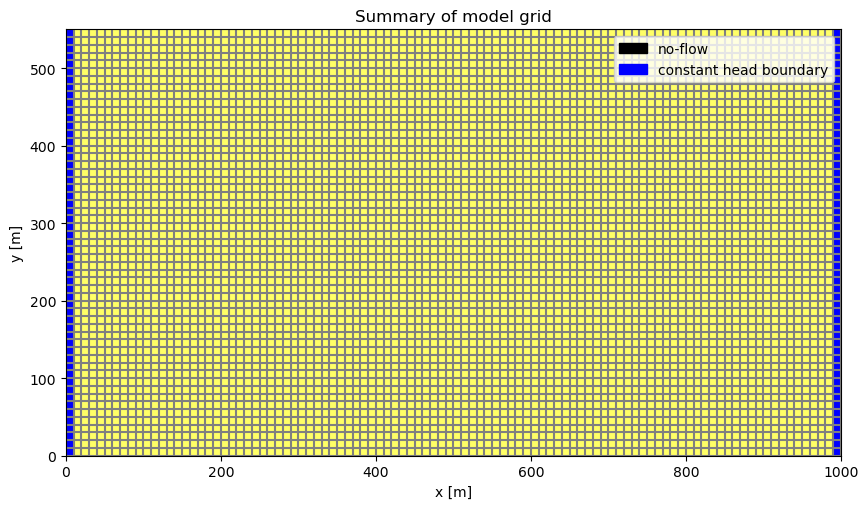

In [15]:
#Plot model boundary conditions summary:
f,ax = plt.subplots(1,1,figsize=(10,10))                    #create new figure and axes
plt.title('Summary of model grid')                          #set figure title
m = flopy.plot.PlotMapView(model=mf, layer=0)               #create model map object
grid = m.plot_grid(colors='gray')                           #plot model grid
r = m.plot_array(rech, cmap='summer_r')                                              #plot recharge array
bc = m.plot_ibound()                       #plot boundary conditions

#Format and legend
plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                    matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                    ])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

In [16]:
mf.write_input()

### 2.2.1 CFPy - write_input

In [17]:
""" initialize write_input module """

input_files = cfpy.write_input(modelname = modelname,
                               data_strings = [coc, crch, cfp],
                               file_extensions = ['coc', 'crch', 'cfp'])

# write CFP input files
input_files.write_input()

### 2.2.2 CFPy - update_nam

In [18]:
""" initialize update_nam module """

nam = cfpy.update_nam(modelname = modelname,
                      mode = 1,
                      cfp_unit_num = 79,
                      crch_unit_num = 80,
                      coc_unit_num = 81)

# update existing .nam file
nam.update_nam()

## 3. Run Model

In [19]:
#Write MODFLOW input files:


#Run MODFLOW:
success, buff = mf.run_model()                 #you should see "normal termination of simulation" printed below

FloPy is using the following  executable to run the model: .\CFPv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/08 12:59:29

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2024/03/08 12:59:30
 ELAPSED RUN TIME:  1.087 SECONDS

  NORMAL TERMINATION OF SIMULATION


## Output

In [20]:
##Get outputs:
#This section usually does not change much

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden

#Get cell-by-cell outputs from the cell budget output file:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells

In [21]:
""" CFPy utilities for node and tube related data """

fr = cfpy.postprocessing.FileReader(
    modelname=modelname)

# array of head at each node at last time step
all_nodes_end = []
all_flow_end = []

# each entry in all_nodes_start should be head at time step zero for a node (will be off by one; i.e. node 1 is indexed 0 in array)
for node in nbr_data[0]:
    node_df, tube_df = fr.read_output(node_num=node, tube_num=None)
    all_nodes_end.append(node_df[node_df.columns[1]][0]) # make 49 dynamic - no. of time steps
for tube in nbr_data[5]:
    node_df, tube_df = fr.read_output(node_num=None, tube_num=tube)
    all_flow_end.append(tube_df)

print(all_nodes_end[0])
print(all_flow_end[0])
# difference in last time step head compared to first time step head
end_hds = np.array(all_nodes_end)
end_flow = np.array(all_flow_end)

C:\Users\HydroResearch\Desktop\Comps_Beck_Arnow_2024_Mar8\CFPy\utils\postprocessing.py:179: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  node_df = pd.read_table(
C:\Users\HydroResearch\Desktop\Comps_Beck_Arnow_2024_Mar8\CFPy\utils\postprocessing.py:179: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  node_df = pd.read_table(
C:\Users\HydroResearch\Desktop\Comps_Beck_Arnow_2024_Mar8\CFPy\utils\postprocessing.py:179: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  node_df = pd.read_table(
C:\Users\HydroResearch\Desktop\Comps_Beck_Arnow_2024_Mar8\CFPy\utils\postprocessing.py:179: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  node_df = pd.read_table(
C:\Users\HydroResearch\Desktop\C

696.0057
   Tube  Beginning Node#  Ending Node# Flow Type  Q [L3 T-1]  Diam. [L]  \
0     1                1             2     TURB.  3388.08346        1.0   

   Len. [L]       Re [-]  Residence Time [T]  
0      10.0  55904.41693             0.00232  


In [22]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read the list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	  142167.38
             RECHARGE_IN' 	        0.0
                PIPES_IN' 	   87917.52
                TOTAL_IN' 	  230084.89
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	 -142167.38
            RECHARGE_OUT' 	       -0.0
               PIPES_OUT' 	  -87917.52
               TOTAL_OUT' 	 -230084.89
                  IN-OUT' 	  0.0026283
     PERCENT_DISCREPANCY' 	        0.0

timesteps: [1.0]
stress periods: [(0, 0)]


In [23]:
# #Get hydraulic head at a specific location (the head you would measure if you installed a piezometer there):

# lay = 0                     #layer piezometer is in
# row = 12                    #row piezometer is in
# col = 42                    #column piezometer is in
# h = head[lay,row,col]       #head at piezometer location

# piezo = np.full((n_lays,n_rows,n_cols), np.nan)  #create array of null values to be able to map piezometer
# piezo[lay,row,col] = 1                     #mark the piezometer location with a 1

vmin = head_mx.min()                      #find the lowest head in entire model (excluding no-flow cells)
vmax = head_mx.max()                      #find the highest head in entire model (excluding no-flow cells)

# text = 'Head at layer {}, row {}, col {}: \t{:.3f} m'   #text to print (print last one with only 3 decimal places, add a tab before the last item)
# print(text.format(lay,row,col,h))  #print and fill curly brackets above with parameter values

# text = 'Min. head anywhere in model: \t\t{} m \nMax. head anywhere in model: \t\t{:.3f} m'
# print(text.format(vmin,vmax))

## Hydraulic Head Distribution

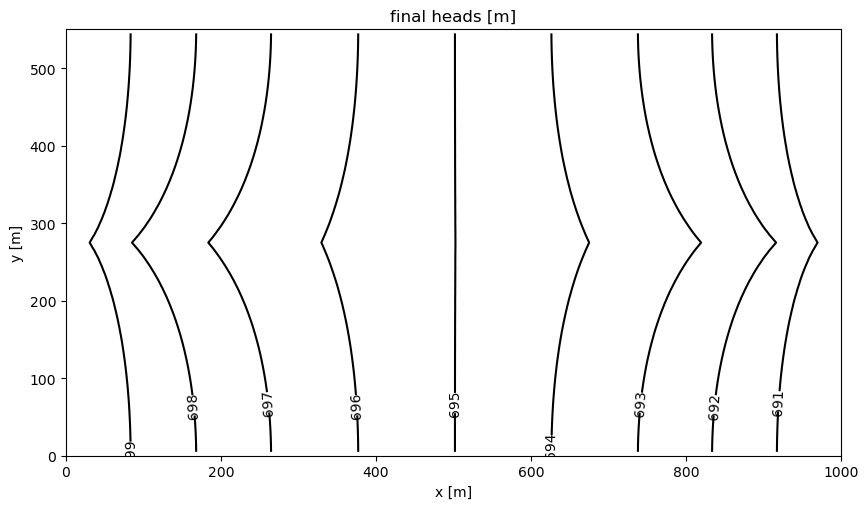

In [24]:
#make axes dividable (to add colorbar)
#Plot the hydraulic heads in layer 1 at the end of the model run

f,ax = plt.subplots(1,1, figsize=(10,10))         #create figure and axis objects
ax.set_title('final heads [m]')                   #set figure title

maps = flopy.plot.PlotMapView(model=mf)           #create flopy map object
# h = maps.plot_array(head[0,:,:], masked_values=[-999.99], cmap='binary')  #plot heads as grayscale map
levels = np.arange(head_mx.min(), head_mx.max(), 1)                       #set contour range and interval
c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels, colors = 'k') #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction 

#Add legend and axis labels

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

#Add colorbar:
divider = make_axes_locatable(ax)                         #make axes dividable (to add colorbar)
# cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
# plt.colorbar(h, cax=cax, orientation='horizontal')        #plot the colorbar

## Conduit Flow

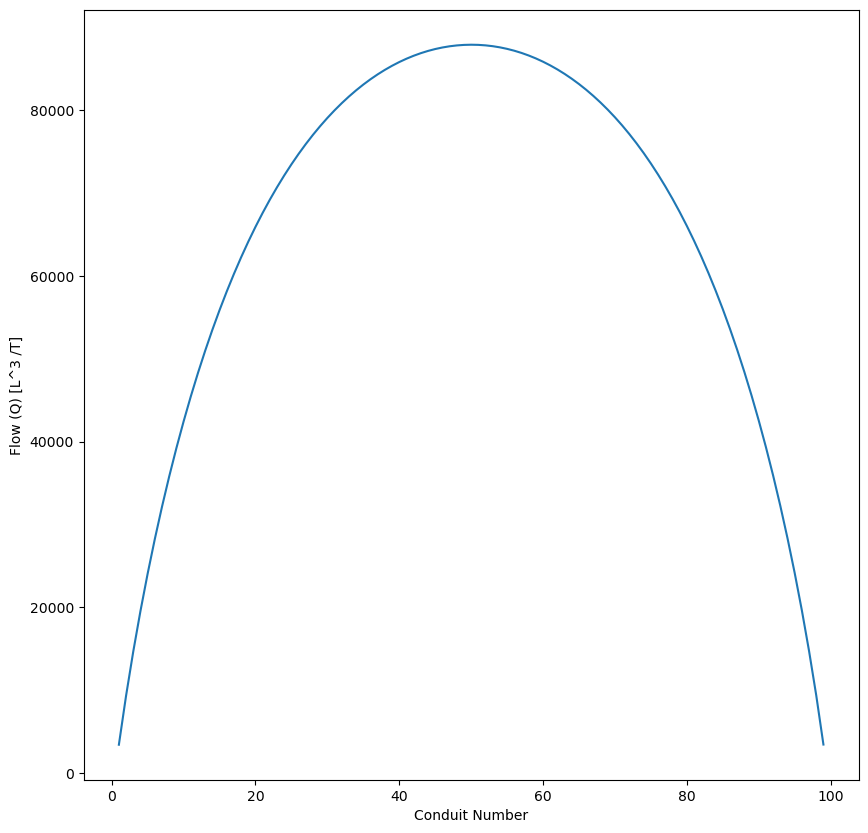

In [25]:
flows = []
tube_nums = []

for i in range(len(end_flow)):
    flows.append(end_flow[i][0][4])
    tube_nums.append(i+1)
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
# ax.plot(tube_nums, flows, label="flow rate", c="m")
# ax.grid(True, alpha=0.4)
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlabel('Conduit Number')
ax.set_ylabel('Flow (Q) [L^3 /T]')
# plt.plot(tube_nums,flows, )
f = plt.plot(tube_nums, flows)
# ax.set_xbound(np.min(flows) , np.max(flows))

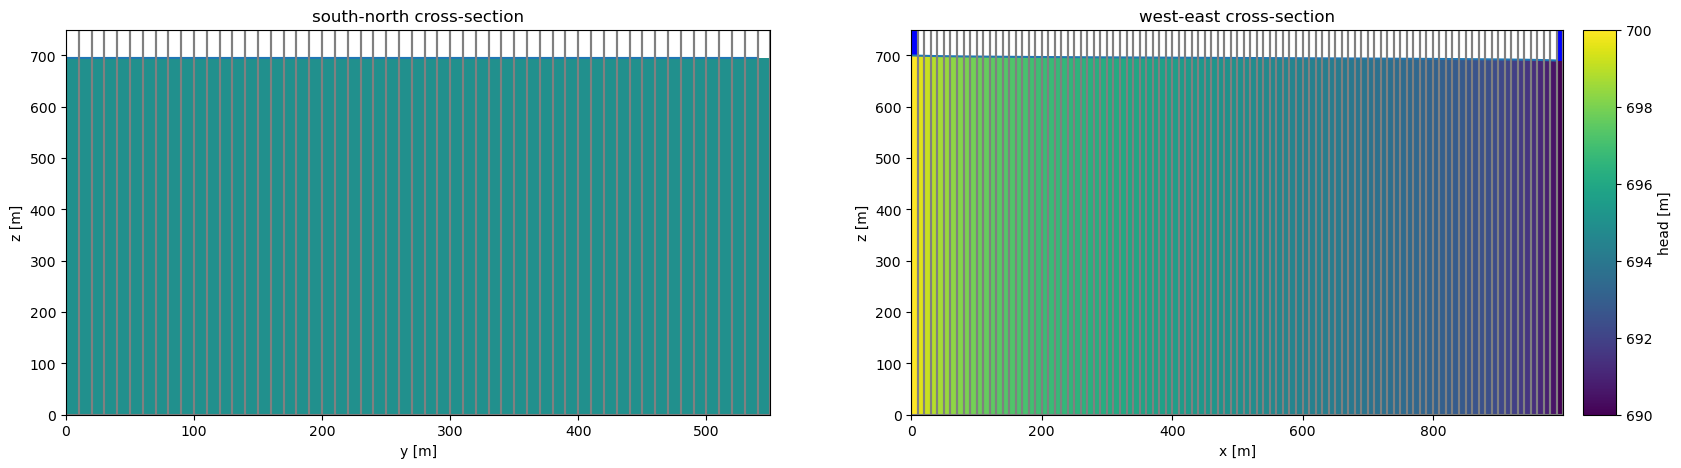

In [26]:
#Plot cross-section view of heads at center row and column:

f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 50})  #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,50])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section')

xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 27})      #plot cross-ection along given row
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
ax[1].plot(np.arange(0,Lx,delc), head_mx[0,27,:])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section')

#Add colorbar:
divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
c.set_label('head [m]')                                  #label the colorbar

### Modpath Addition

In [27]:
#Run MODPATH for particle tracking:
mp = flopy.modpath.Modpath6(modelname=modelname+'_mp', exe_name='mp6.exe', 
        modflowmodel=mf, model_ws=None, dis_file=modelname+'.dis', 
        head_file=modelname+'.hds', budget_file=modelname+'.cbc')                 #create MODPATH model object
mpb = flopy.modpath.Modpath6Bas(mp, hdry=mf.lpf.hdry, laytyp=mf.lpf.laytyp, 
        ibound=ibound)                                                  #create MODPATH BAS object
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH')     #create MODPATH simulation

mp.write_input()                 #write MODPATH input files
mp.run_model(silent=False)       #run MODPATH - you should see "Normal termination" printed below

FloPy is using the following  executable to run the model: .\mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

In [28]:
#Get MODPATH outputs: 
#load the endpoint data:
endobj = flopy.utils.EndpointFile(mp.sim.endpoint_file)   #get the raw MODPATH endpoint file
ept = endobj.get_alldata()                                 #import the endpoint data to FloPy
#convert ept to an array:
ept_array = np.zeros((len(ept),len(ept[0])-1))             #create an empty array the same dimensions as the ept file
for row in np.arange(len(ept)):                            #loop over the ept file rows
    for col in np.arange(len(ept[0])-1):                   #loop over the ept file columns (except the last one)
        ept_array[row,col] = ept[row][col]                 #assign each ept item to the array
        
#load the pathline data:
pthobj = flopy.utils.PathlineFile(mp.sim.pathline_file)
plines = pthobj.get_alldata()

## Particle Transport

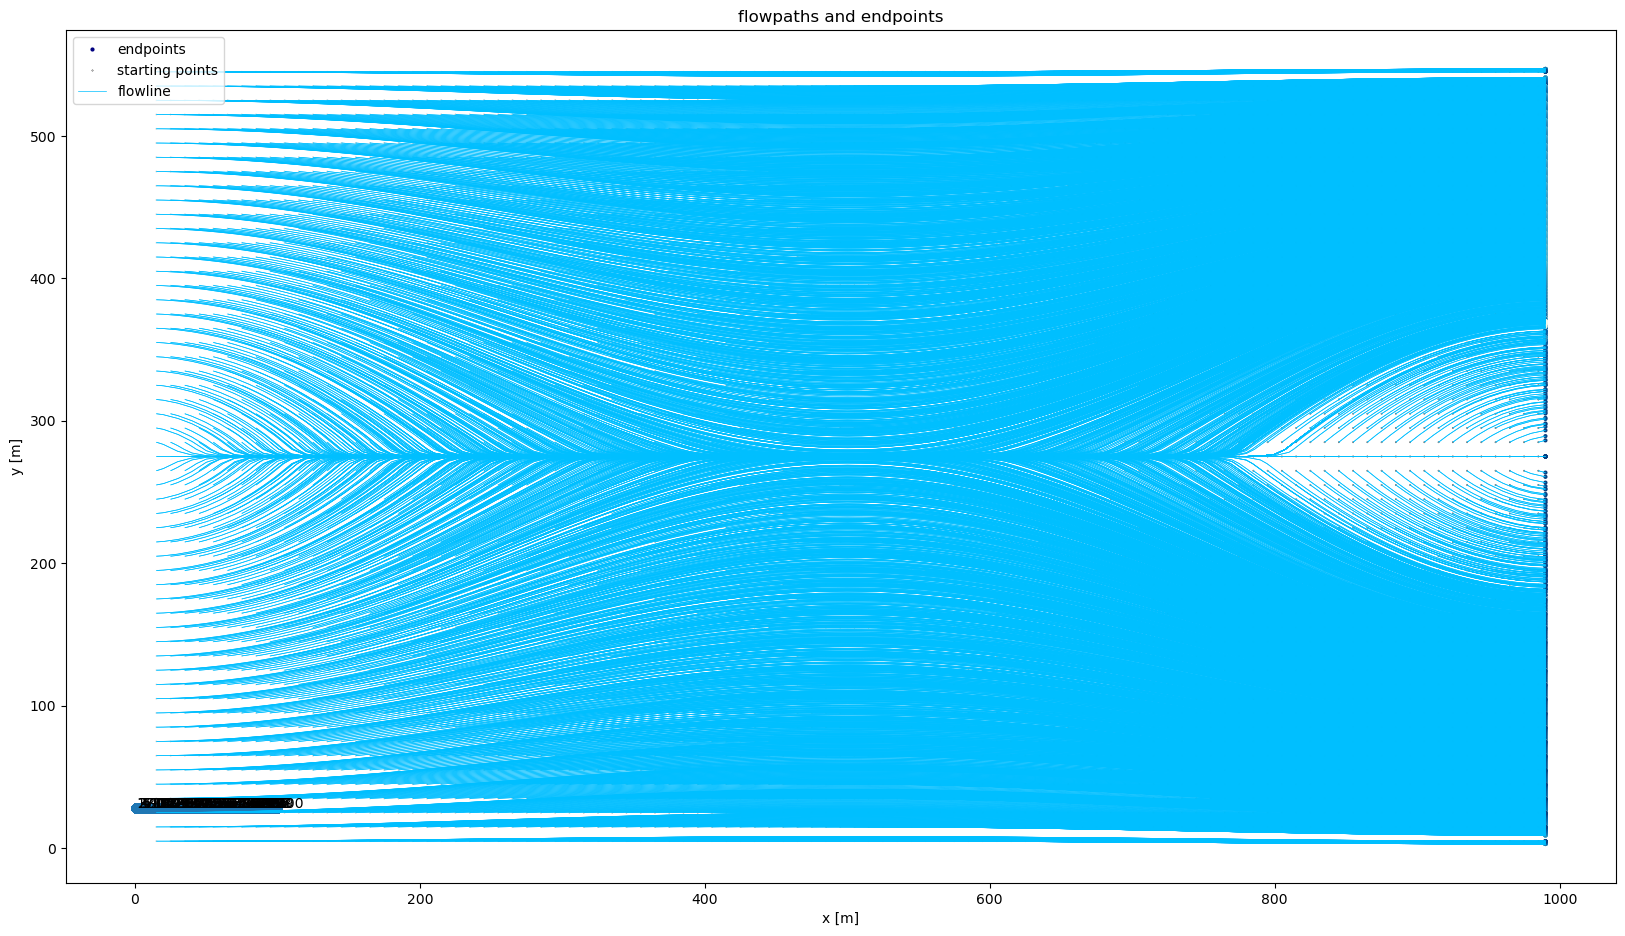

In [29]:
#Plot flowpath and endpoints:
plot_all = True

f,ax = plt.subplots(1,1, figsize=(20, 20))              #make new figure and axes
ax.set_title('flowpaths and endpoints')
maps = flopy.plot.PlotMapView(model=mf)                 #make map object
#h = maps.plot_array(head, masked_values=[-999.99], alpha=0.25) #uncomment to plot heads as colors
#f = maps.plot_vector(frf, fff)                                #uncomment to plot vectors of flow direction in each cell
if plot_all:
    l = maps.plot_pathline(plines, layer=0, colors='deepskyblue', lw=0.5)   #plot all flowlines
else:
    n = 10                                                  #number out of which to select flowlines
    pind = np.arange(0, len(plines)-1, n, dtype=int)        #get one in every n indices
    plines10 = [plines[i] for i in pind]                     #use indices to get one in every n pathlines
    l = maps.plot_pathline(plines10, layer=0, colors='deepskyblue', lw=0.5)   #plot one in n flowlines
e = maps.plot_endpoint(ept, cmap='GnBu_r', s=2)                #plot endpoints of particles
e = maps.plot_endpoint(ept, direction='starting', cmap='binary_r', s=0.25)  #plot starting points of particles

plt.legend(handles=[matplotlib.lines.Line2D([],[], color='navy', marker='o', linestyle='None', markersize=2, label='endpoints'),
                    matplotlib.lines.Line2D([],[], color='black', marker='.', linestyle='None', markersize=0.5, label='starting points'),
                    matplotlib.lines.Line2D([],[], color='deepskyblue', linewidth=0.5, label='flowline')]) #add legend manually
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

node_locs = []
for n in nbr_data[2]:
    node_locs.append(n[0:2])
x, y = zip(*node_locs)
node_labs = nbr_data[0]

x_adj = x * 1000
y_adj = y * 1000

plt.scatter(x_adj, y_adj)

#plot node labels
lab_locs = zip(x_adj, y_adj, node_labs)
for n in lab_locs:
    plt.text(n[0], n[1] + 0.3, n[2])